# Modules

In [1]:
import pandas as pd
import numpy as np
import warnings
import datetime
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_history_alive


warnings.filterwarnings("ignore")

# Functions

In [2]:
# Updata functionq based on  https://github.com/CamDavidsonPilon/lifetimes/blob/master/lifetimes/plotting.py

def plot_period_transactions(
    model,
    max_frequency=7,
    title="Fréquence des transactions",
    xlabel="Nombre de transactions",
    ylabel="Clients",
    **kwargs
    ):
    """
    Plot a figure with period actual and predicted transactions.
    Parameters
    ----------
    model: lifetimes model
        A fitted lifetimes model.
    max_frequency: int, optional
        The maximum frequency to plot.
    title: str, optional
        Figure title
    xlabel: str, optional
        Figure xlabel
    ylabel: str, optional
        Figure ylabel
    kwargs
        Passed into the matplotlib.pyplot.plot command.
    Returns
    -------
    axes: matplotlib.AxesSubplot
    """
    from matplotlib import pyplot as plt

    labels = kwargs.pop("label", ["Actual", "Model"])

    n = model.data.shape[0]
    simulated_data = model.generate_new_data(size=n)

    model_counts = pd.DataFrame(model.data["frequency"].value_counts().sort_index().iloc[:max_frequency])
    simulated_counts = pd.DataFrame(simulated_data["frequency"].value_counts().sort_index().iloc[:max_frequency])
    combined_counts = model_counts.merge(simulated_counts, how="outer", left_index=True, right_index=True).fillna(0)
    combined_counts.columns = labels

    ax = combined_counts.plot(kind="bar", **kwargs)

    plt.legend()
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    return ax

In [3]:
def customize_corr(df: pd.DataFrame) :
    
    """ 
      Customize correlation matrix visually  
      
    Arguments:
        df - dataframe with features
    
    Returns: 
    """
    
    # modules
    import matplotlib.pyplot as plt
    import seaborn as sns
    plt.figure(figsize=(16, 10))
    
    # define the mask to set the values in the upper triangle to True
    mask = np.triu(np.ones_like(df.corr()))
    heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='magma')
    heatmap.set_title('Lower Correlation Matrix', fontdict={'fontsize':18}, pad=16)

# Data

In [4]:
transaction = pd.read_pickle('intermed/sales.sav')
transaction['tran_date'] = pd.to_datetime(transaction["tran_date"].str.replace('/','-'), format = '%d-%m-%Y')
transaction.head()

,customer_Id,DOB,Gender,city_code,prod_cat_code,prod_cat,prod_sub_cat_code,prod_subcat,transaction_id,cust_id,tran_date,prod_subcat_code,Qty,Rate,Tax,total_amt,Store_type,transaction_date
0,268408,1970-01-02,M,4.0,1,Clothing,1,Women,63314547725,268408,2012-04-26,1,1,806,84.630,890.630,Flagship store,2012-04-26
1,268408,1970-01-02,M,4.0,2,Footwear,1,Mens,56844530655,268408,2012-10-14,1,5,1175,616.875,6491.875,MBR,2012-10-14
2,268408,1970-01-02,M,4.0,2,Footwear,4,Kids,64633435931,268408,2013-05-06,4,3,312,98.280,1034.280,Flagship store,2013-05-06
3,268408,1970-01-02,M,4.0,3,Electronics,9,Cameras,56902862040,268408,2013-01-30,9,5,868,455.700,4795.700,e-Shop,2013-01-30
4,268408,1970-01-02,M,4.0,3,Electronics,10,Audio and video,19516063887,268408,2012-09-07,10,4,650,273.000,2873.000,e-Shop,2012-09-07


In [5]:
rfm = pd.read_pickle('intermed/rfm.sav')
rfm = rfm[rfm.monetary_value>0]
rfm.head()

,customer_Id,frequency,recency,T,monetary_value,R,F,M,RFM_Segment,RFM_Score,Segment,Score
0,266783,3.0,516.0,881.0,1037.963333,2,2,1,2.02.01.0,5,Hibernating,Green
1,266784,2.0,103.0,546.0,707.200000,1,2,1,1.02.01.0,4,Hibernating,Green
2,266785,6.0,870.0,1073.0,3588.487500,4,4,4,4.04.04.0,12,Champions,Platinum
3,266788,3.0,611.0,984.0,1574.993333,2,2,2,2.02.02.0,6,Hibernating,Bronze
4,266794,9.0,1062.0,1070.0,2839.113333,4,4,3,4.04.03.0,11,Champions,Platinum


# CLV estimation for 2 years

## Modele NBD/Pareto

In [6]:
bgf = BetaGeoFitter(penalizer_coef=0.0000005)
bgf.fit(rfm['frequency'], round(rfm['recency']/30), round(rfm['T']/30))
round(bgf.summary, 3)
# r, α, s, β

,coef,se(coef),lower 95% bound,upper 95% bound
r,68.422,7.805,53.124,83.720
alpha,624.455,71.521,484.273,764.637
a,0.461,0.238,-0.005,0.927
b,17.826,8.495,1.176,34.476


<AxesSubplot:title={'center':'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

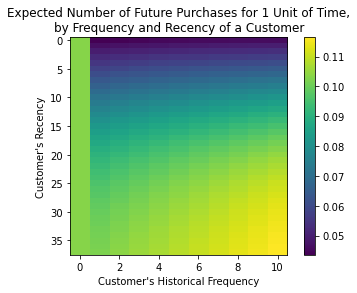

In [7]:
from lifetimes.plotting import plot_frequency_recency_matrix
plot_frequency_recency_matrix(bgf)

Nos clients qui sont susceptible d'effectuer des achats sont ceux qui achètent le plus souvent (en terme de nombre de transaction) 

Ils semblent que la récence d'a pas trop d'impact sur les futures tranactionsd'un client.
Nos clients les plus importants sont celles ayant le plus

Les clients qui ont beaucoup acheté et acheté récemment seront probablement les meilleurs clients à l'avenir.
Nous n'en aurons jamais assez.
Les clients qui ont acheté beaucoup mais pas récemment (coin supérieur droit) sont probablement partis.

<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

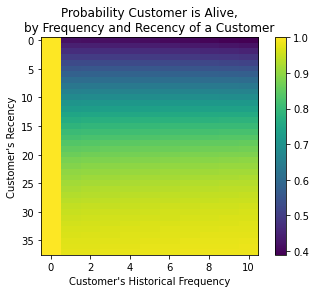

In [8]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

Pour rappel, Recency représente  la durée entre le premier achat d'un client et son dernier achat.
Les clients qui ont achété une seule fois dépuis longtemps ont une probabilité de churn très élévée.

In [9]:
t = 6
rfm['predicted_purchases'] = round(bgf.conditional_expected_number_of_purchases_up_to_time(t,rfm['frequency'], round(rfm['recency']/30), round(rfm['T']/30)),1)
rfm.sort_values(by='predicted_purchases').tail()


,customer_Id,frequency,recency,T,monetary_value,R,F,M,RFM_Segment,RFM_Score,Segment,Score,predicted_purchases
2133,270071,6.0,1019.0,1026.0,2951.455000,4,4,3,4.04.03.0,11,Champions,Platinum,0.7
773,267987,7.0,982.0,1121.0,1997.050714,4,4,2,4.04.02.0,10,Champions,Gold,0.7
2134,270072,5.0,944.0,958.0,1447.329000,4,4,2,4.04.02.0,10,Champions,Gold,0.7
2071,269967,5.0,734.0,794.0,2406.027000,3,4,3,3.04.03.0,10,Loyal customers,Gold,0.7
3359,271961,7.0,1053.0,1122.0,2241.729286,4,4,2,4.04.02.0,10,Champions,Gold,0.7


Grace à l'estimation, on peut prédire le nombre de transaction futures des clients. Ci-haut se trouve par exemple l'estimation dU nombre de transaction les 6 prochains moyens

<AxesSubplot:title={'center':'Fréquence des transactions'}, xlabel='Nombre de transactions', ylabel='Clients'>

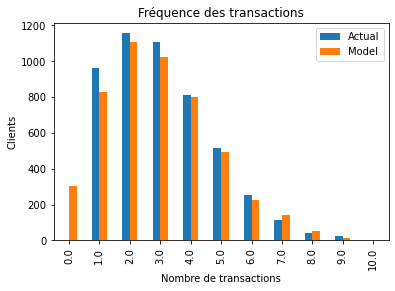

In [10]:
# Générer des données artificielles selon le modèle MBG/NBD et les compararer aux vrais valeurs
plot_period_transactions(bgf,max_frequency=10)

Nous pouvons voir que nos données réelles et nos données simulées s'ajustent très bien.

In [11]:
from lifetimes.utils import calibration_and_holdout_data
sales_df = pd.read_pickle('intermed/sales')
sales_df['tran_date'] = pd.to_datetime(sales_df["tran_date"].str.replace('/','-'), format = '%d-%m-%Y')
sales_df = sales_df.sort_values(by=['customer_Id','tran_date'])

summary_cal_holdout = calibration_and_holdout_data(sales_df, 'customer_Id','tran_date',
                                        calibration_period_end='2014-01-05',
                                        observation_period_end='2014-02-20' )
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
customer_Id,,,,,
266783,4.0,516.0,835.0,0.0,46.0
266784,2.0,103.0,500.0,0.0,46.0
266785,7.0,870.0,1027.0,0.0,46.0
266788,3.0,611.0,938.0,0.0,46.0
266794,9.0,835.0,1024.0,1.0,46.0


<AxesSubplot:title={'center':'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

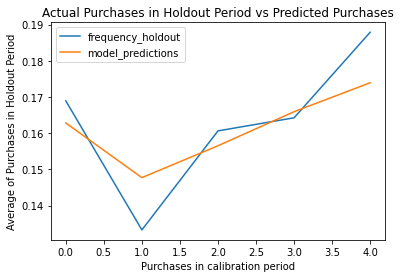

In [12]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
bgf.fit( summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout,n=5)

In [13]:
t = 180 # predire les achats pour 6 mois
temp = rfm.iloc[1999]
print(temp)
# En fait predit  = = onditional_expected_number_of_purchases_up_to_time
print('***************')
print("nombre de transaction prédites :", round(bgf.predict(t, temp['frequency'], temp['recency'], temp['T']/30),1))


customer_Id                 270171
frequency                      3.0
recency                      377.0
T                           1018.0
monetary_value            1914.965
R                                2
F                                2
M                                2
RFM_Segment              2.02.02.0
RFM_Score                        6
Segment                Hibernating
Score                       Bronze
predicted_purchases            0.5
Name: 2198, dtype: object
***************
nombre de transaction prédites : 0.8


<AxesSubplot:title={'center':'History of P_alive'}, ylabel='P_alive'>

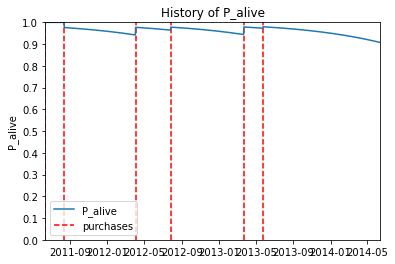

In [14]:
CUSTOMER_ID =  269864
days_since_birth = 365*3 # Trois ans
cust_transaction= transaction[transaction.customer_Id == CUSTOMER_ID]
plot_history_alive(bgf, days_since_birth, cust_transaction, 'tran_date')

Ce client aura certainement un achat dans les prochains 6 mois

## Gamma-Gamma submodel

Comme l'on a pu remarqué le modèle NBD/pareto ne tient pas compte que la valeur monétaire des transaction. Il nous permet d'estimer le nombre de transaction seulement.

C'est pourquoi pour l'estimation dU CLV on utilise le modèle gamma gamma.
Ce modèle estime d'abord la valeur moyenne monétaire moyenne s en tenant compte de l'historiques des transaction et des valeurs futures. Par suite, l'on peut estime directement le CLV

On rappelle que Gamma Gamma à une hypothèse d'indpendance entre la fréquence des achats et le montnats des achats. Chose que nous pouvons verifier très facilement.


In [15]:
print("************* Correlation de Pearson**********")

print(round(rfm[['frequency','monetary_value']].corr(method='pearson'),2))
print("\n*********** Correlation de Spearman****************")
print(round(rfm[['frequency','monetary_value']].corr(method='spearman'),2))

************* Correlation de Pearson**********
                frequency  monetary_value
frequency            1.00            0.02
monetary_value       0.02            1.00

*********** Correlation de Spearman****************
                frequency  monetary_value
frequency            1.00            0.11
monetary_value       0.11            1.00


In [16]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0.0001)
ggf.fit(rfm['frequency'], rfm['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 4993 subjects, p: 37.26, q: 1.07, v: 37.42>


In [17]:
rfm['monetary_value_pred']=ggf.conditional_expected_average_profit(rfm['frequency'],rfm['monetary_value'])


In [18]:
rfm['CLV'] = ggf.customer_lifetime_value(
                            bgf, #le  model utilisé pour predire les  transactions futures
                            rfm['frequency'],
                            rfm['recency'],
                            rfm['T'],
                            rfm['monetary_value'],
                            time=365*2, # deux ans
                             )

In [19]:
rfm

,customer_Id,frequency,recency,T,monetary_value,R,F,M,RFM_Segment,RFM_Score,Segment,Score,predicted_purchases,monetary_value_pred,CLV
0,266783,3.0,516.0,881.0,1037.963333,2,2,1,2.02.01.0,5,Hibernating,Green,0.6,1049.818664,9271.327526
1,266784,2.0,103.0,546.0,707.200000,1,2,1,1.02.01.0,4,Hibernating,Green,0.6,725.269356,6185.250240
2,266785,6.0,870.0,1073.0,3588.487500,4,4,4,4.04.04.0,12,Champions,Platinum,0.6,3593.666993,36499.510753
3,266788,3.0,611.0,984.0,1574.993333,2,2,2,2.02.02.0,6,Hibernating,Bronze,0.6,1586.532957,13794.009613
4,266794,9.0,1062.0,1070.0,2839.113333,4,4,3,4.04.03.0,11,Champions,Platinum,0.7,2842.713571,33144.755230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5501,275257,3.0,637.0,808.0,4097.340000,3,2,4,3.02.04.0,9,Potential loyalists,Silver,0.6,4107.396798,38469.639324
5502,275261,2.0,740.0,878.0,1649.765000,3,2,2,3.02.02.0,7,Potential loyalists,Bronze,0.6,1667.003434,14847.737130
5503,275262,1.0,200.0,922.0,3328.260000,1,1,4,1.01.04.0,6,Hibernating,Bronze,0.5,3359.749741,21740.843623
5504,275264,1.0,64.0,930.0,2594.540000,1,1,3,1.01.03.0,5,Hibernating,Green,0.4,2627.322229,14108.798302
